### Baseline Calibration

In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable


import numpy as np 
import pathlib
import pandas as pd
import scipy as sp
import pickle
import sys
import itertools

import floris.layout_visualization as layoutviz
from floris import (
    FlorisModel,
    TimeSeries,
    WindRose,
    WindTIRose,
)
from floris.flow_visualization import visualize_cut_plane

library_path = '../'
if library_path not in sys.path:
    sys.path.append(library_path)
import calibrate_floris as cf
import floris
print(f"The source file for the floris library is located at: {floris.__file__}")

The source file for the floris library is located at: /projects/wind_uq/gyalla/src/python/TCF_03_24_2025/lib/python3.12/site-packages/floris/__init__.py


### SETUP FLORIS CASES 

In [18]:
#Define list of cases 
cases = [
    "MedWS_LowTI_Baseline_6D_45",
]

#Specify setup files to be generated for each case
setup_files = {}
setup_files = {}
setup_files[cases[0]] = 'MedWS_LowTI_Baseline_6D_45_emgauss.yaml'

baseline_array = ['baseline','baseline','baseline','baseline','baseline','baseline','baseline','baseline','baseline']
awc_amplitudes = [4,4,4,4,4,4,4,4,4]

In [20]:

floris_models = {}
for caseiter, case in enumerate(cases):
    floris_model = FlorisModel(setup_files[case],)
    floris_models[case] = floris_model
    floris_model.set_operation_model("awc")
    floris_model.set(
    awc_modes=np.array([baseline_array]),
    awc_amplitudes=np.array([awc_amplitudes]))
    floris_models[case] = floris_model
    print("Setup floris model for " + case + " with configuration file: ", floris_model.configuration)



Setup floris model for MedWS_LowTI_Baseline_6D_45 with configuration file:  MedWS_LowTI_Baseline_6D_45_emgauss.yaml


### Wind Rose

Wind Speeds:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
Wind Directions:  [ 12.  24.  36.  48.  60.  72.  84.  96. 108. 120. 132. 144. 156. 168.
 180. 192. 204. 216. 228. 240. 252. 264. 276. 288. 300. 312. 324. 336.
 348. 360.]
TI:  [0.01666667 0.03333333 0.05       0.06666667 0.08333333 0.1
 0.11666667 0.13333333 0.15       0.16666667 0.18333333 0.2
 0.21666667 0.23333333 0.25       0.26666667 0.28333333 0.3
 0.31666667 0.33333333 0.35       0.36666667 0.38333333 0.4
 0.41666667 0.43333333 0.45       0.46666667 0.48333333 0.5       ]


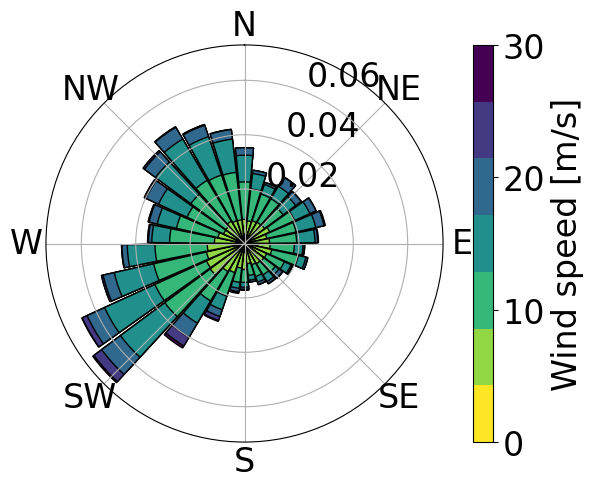

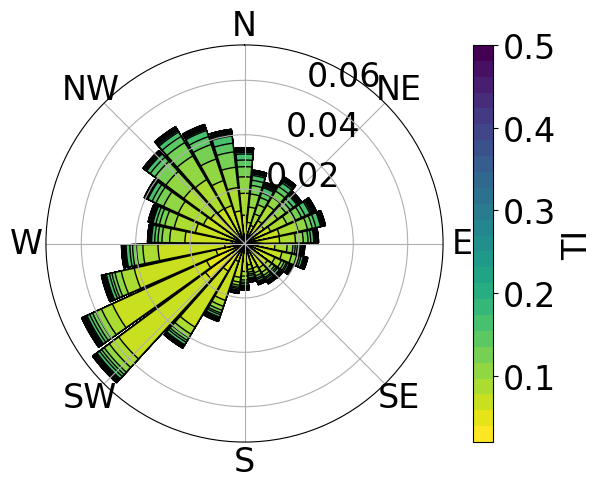

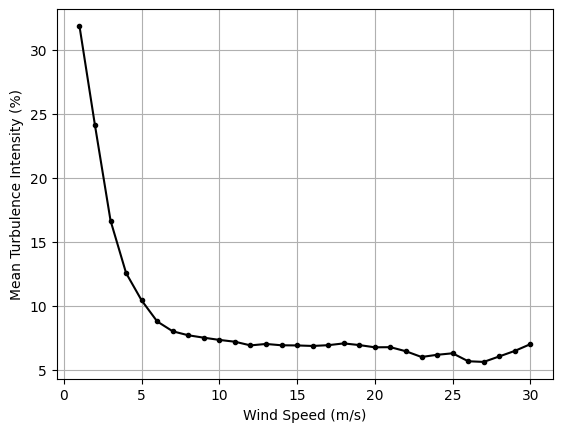

In [21]:
with open('./3D_weibull_data.pkl', 'rb') as f:
    wd_data, ti_data, ws_data = pickle.load(f)

#wd_data = 5*np.ones_like(wd_data)
#3D histogram
#wd_data = 225*np.ones_like(wd_data)
sample = np.column_stack((wd_data,ws_data,ti_data))
hist , edges = np.histogramdd(sample, bins=30, range=((0,360),(0,30),(0,0.5)))
# The WindTIRose class is similar to the WindRose table except that TI is also binned
# making the frequency table a 3D array.
wind_directions = edges[0][1:]
wind_speeds = edges[1][1:]
turbulence_intensities = edges[2][1:]
print("Wind Speeds: ",wind_speeds)
print("Wind Directions: ",wind_directions)
print("TI: ",turbulence_intensities)
# Uniform value
value_table = np.ones((len(wind_directions), len(wind_speeds), len(turbulence_intensities)))

wind_ti_rose = WindTIRose(
    wind_directions=wind_directions,
    wind_speeds=wind_speeds,
    turbulence_intensities=turbulence_intensities,
    freq_table=hist,
    value_table=value_table,
)

wind_ti_rose.plot(wd_step=12,wind_rose_var='ws',wind_rose_var_step=5)
wind_ti_rose.plot(wd_step=12,wind_rose_var='ti',legend_kwargs={'label':'TI'},wind_rose_var_step=0.02)

# Showing TI over wind speed for a WindRose
wind_ti_rose.plot_ti_over_ws()

In [22]:
n_wd = len(wind_ti_rose.wind_directions)
n_ws = len(wind_ti_rose.wind_speeds)
n_ti = len(wind_ti_rose.turbulence_intensities)
flat_table = wind_ti_rose.freq_table.flatten()
table_3D = wind_ti_rose.freq_table
awc_settings = np.array([baseline_array]*n_wd*n_ws*n_ti)

#See line 1239 in wind_data.py
wd_grid,ws_grid,ti_grid = np.meshgrid(wind_ti_rose.wind_directions,wind_ti_rose.wind_speeds,wind_ti_rose.turbulence_intensities,indexing='ij')
wd_flat = wd_grid.flatten()
ws_flat = ws_grid.flatten()
ti_flat = ti_grid.flatten()

baseline_array = ['baseline','baseline','baseline','baseline','baseline','baseline','baseline','baseline','baseline']
for i in range(n_wd*n_ws*n_ti):
    #if ws_flat[i] > 15.0 or ti_flat[i] > 0.1:
    awc_settings[i,:] = baseline_array
mask_non_zero = wind_ti_rose.freq_table.flatten() != 0
awc_settings = awc_settings[mask_non_zero,:]



In [24]:
# See line 317 in /projects/wind_uq/gyalla/src/python/TCF_01_13_2025/lib/python3.13/site-packages/floris/
aeps = {}
for case in cases:
    print(case)
    fmodel = floris_models[case]
    fmodel.set(wind_data=wind_ti_rose)
    baseline_settings = np.array([baseline_array]*fmodel.core.flow_field.n_findex)
    awc_amps = np.array([awc_amplitudes]*fmodel.core.flow_field.n_findex)

    if "Baseline" in case:
        fmodel.set(
            wind_data=wind_ti_rose,
            awc_modes=baseline_settings,
            awc_amplitudes=awc_amps)
    else:
        fmodel.set(
            wind_data=wind_ti_rose,
            awc_modes=awc_settings,
            awc_amplitudes=awc_amps)

    #for i in range(len(ws_flat[mask_non_zero])):
    #    print(ws_flat[i],awc_settings[i,:])


    n_wd = len(wind_ti_rose.wind_directions)
    n_ws = len(wind_ti_rose.wind_speeds)
    n_ti = len(wind_ti_rose.turbulence_intensities)
    # Store the number of elements of the freq_table which are 0
    n_zeros = np.sum(wind_ti_rose.freq_table == 0)
    # Run the model
    fmodel.run()
    # Note that the frequency table contains 0 frequency for some wind directions and wind speeds
    # and we've not selected to compute 0 frequency bins, therefore the n_findex will be less than
    # the total number of wind directions and wind speed combinations
    print(f"Total number of wind direction, wind speed, and TI combination: {n_wd * n_ws * n_ti}")
    print(f"Number of 0 frequency bins: {n_zeros}")
    print(f"n_findex: {fmodel.n_findex}")

    # Get the AEP
    aep = fmodel.get_farm_AEP()
    aeps[case] = aep

    # Print the AEP
    print(f"AEP from wind rose: {aep/1E9:.3f} (GWh)")

    # Run the model again, without wakes, and use the result to compute the wake losses
    fmodel.run_no_wake()

    # Get the AEP without wake
    aep_no_wake = fmodel.get_farm_AEP()

    # Compute the wake losses
    wake_losses = 100 * (aep_no_wake - aep) / aep_no_wake
    print(f"Wake losses: {wake_losses:.2f}%")
    print()

MedWS_LowTI_Baseline_6D_45
Total number of wind direction, wind speed, and TI combination: 27000
Number of 0 frequency bins: 20444
n_findex: 6556
AEP from wind rose: 745.956 (GWh)
Wake losses: 2.48%



In [25]:
# See line 317 in /projects/wind_uq/gyalla/src/python/TCF_01_13_2025/lib/python3.13/site-packages/floris/
aeps = {}
for case in cases:
    fmodel = floris_models[case]
    fmodel.set(wind_data=wind_ti_rose)
    baseline_settings = np.array([baseline_array]*fmodel.core.flow_field.n_findex)
    awc_amps = np.array([awc_amplitudes]*fmodel.core.flow_field.n_findex)

    fmodel = FlorisModel(setup_files[case])
    fmodel.set_operation_model("awc")
    if 'Baseline' in case:
        fmodel.set(
            wind_data=wind_ti_rose,
            awc_modes=baseline_settings,
            awc_amplitudes=awc_amps)
    else:
        fmodel.set(
            wind_data=wind_ti_rose,
            awc_modes=awc_settings,
            awc_amplitudes=awc_amps)

    fmodel.run()

    aep_awc = fmodel.get_farm_AEP()
    print(f"AEP AWC: {aep_awc/1E9:.3f} (GWh)")
#print(f"AEP change: {100 * (aep_awc- aep_baseline)/aep_baseline:.2f}%")


AEP AWC: 745.956 (GWh)
